In [7]:
import time
import random
import copy
import numpy as np
from PIL import Image
from PIL import EpsImagePlugin
import tkinter as tk
%matplotlib inline
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import statistics

#To calculate execution time
start_time = time.time()

#read points and size of the board
def read_data(filename):
    with open(filename) as f:
        board_size = list(map(lambda x: int(x) + 1, f.readline().split(';')))
        coordinates = [list(map(lambda x: int(x) + 1, i.split(';'))) for i in f.readlines()]
        return board_size, coordinates

#CONSTANTS
POPULATION_SIZE = 10
CROSSOVER_CHANCE = 0.7
MUTATION_CHANCE = 0.45
GENERATIONS = 50
SPACE_BETWEEN_POINTS = 50
MUTATION_SEGMENT_DISTANCE = 1
MUTATION_SEGMENT_LENGTH = 2
MAX_SEGMENTS = 3
MAX_SEGMENT_DISTANCE = 3
FITNESS_VALUES = [22, 0.5, 1, 18, 18]

(board_width, board_height), coordinates = read_data('file2.txt')


class Path:

    def __init__(self, xstart=0, ystart=0, xend=0, yend=0):
        self.xstart = xstart
        self.ystart = ystart
        self.xend = xend
        self.yend = yend
        self.segments = []
        self.color = '#%06X' % random.randint(0, 256 ** 3)

    def __str__(self):
        return '(%s, %s); (%s, %s);\n' % (self.xstart, self.ystart, self.xend, self.yend) + '\t'.join(str(i) for i in self.segments)


class Segment:

    def __init__(self, direction='', distance=0):
        self.direction = direction
        self.distance = distance

    def __str__(self):
        return '[%s, %s]' % (self.direction, self.distance)

class Individual:

    def __init__(self):
        self.paths = []

    def __str__(self):
        return '\n'.join(str(i) for i in self.paths)

    def fitness_score(self):
        result = []
        intersections = 0
        total_path_length = 0
        total_segments_count = 0
        total_distance_outside = 0
        total_segments_outside = 0
        
        for path in self.paths:
            total_segments_count += len(path.segments)
            x, y = path.xstart, path.ystart

            for segment in path.segments:

                for i in range(segment.distance):
                    if x <= 0 or y <= 0 or x > board_width or y > board_height: 
                        total_distance_outside += 1
                    if segment.direction == 'U':
                         y -= 1
                    if segment.direction == 'D':
                         y += 1
                    if segment.direction == 'L':
                         x -= 1
                    if segment.direction == 'R':
                         x += 1
                
                idx = path.segments.index(segment)
                counter = 0
                if segment.direction == 'D' and y - segment.distance <= 0: 
                    counter += 1
                if segment.direction == 'U' and y + segment.distance > board_height: 
                    counter += 1
                if segment.direction == 'R' and x - segment.distance <= 0: 
                    counter += 1 
                if segment.direction == 'L' and x + segment.distance > board_width: 
                    counter += 1
                if counter > 0 :
                    segment.distance = 0

                total_path_length += segment.distance 
                xend, yend = path.xend, path.yend

                if x <= 0 or x > board_width or y <= 0 or y >= board_height: 
                    total_segments_outside += 1
                else:
                    if segment.direction == 'U': 
                        yend -= segment.distance
                    if segment.direction == 'D': 
                        yend += segment.distance
                    if segment.direction == 'L': 
                        xend -= segment.distance
                    if segment.direction == 'R': 
                        xend += segment.distance

                result.append([x, y, xend, yend, path])
                
        for i in range(len(result) - 1):
            for j in range(i + 1, len(result)):
                if intersection(*result[i][:-1], *result[j][:-1]):
                    intersections += 1

        total_distance_outside += 1 if total_distance_outside != 0 else 0

        return sum([a * b for a, b in zip([intersections, total_path_length, total_segments_count, ], FITNESS_VALUES)])

       
def create_segments(path: Path):
    segments = []
    x, y = path.xstart, path.ystart
    previous_direction = None

    for i in range(random.randint(0, MAX_SEGMENTS)):
        if x == path.xend and y == path.yend: 
            return segments

        dirs = [*'UDLR']
        if previous_direction: 
            dirs.remove(previous_direction)
        if previous_direction == 'U': 
            dirs.remove('D')    
        if previous_direction == 'D': 
            dirs.remove('U')
        if previous_direction == 'L': 
            dirs.remove('R')
        if previous_direction == 'R': 
            dirs.remove('L')

        dr = random.choice(dirs)
        ds = random.randint(1, MAX_SEGMENT_DISTANCE)
        segment = Segment(dr, ds)
        segments.append(segment)

        if dr == 'U': 
            y -= ds
        if dr == 'D': 
            y += ds
        if dr == 'L': 
            x -= ds
        if dr == 'R': 
            x += ds
        previous_direction = dr

    segments += connect_segments(Path(x, y, path.xend, path.yend))
    return segments


def connect_segments(path):
    if path.xstart == path.xend:
        if path.ystart < path.yend: return [Segment('D', path.yend - path.ystart)]
        elif path.ystart > path.yend: return [Segment('U', path.ystart - path.yend)]
        else: return []

    if path.ystart == path.yend:
        if path.xstart > path.xend: return [Segment('L', path.xstart - path.xend)]
        elif path.xstart < path.xend: return [Segment('R', path.xend - path.xstart)]
        else: return []

    segments = []
    previous_direction = None
    for r in range(2):
        if str(previous_direction) in 'UD': 
            segment = Segment('R' if path.xstart < path.xend else 'L', abs(path.xstart - path.xend))

        elif str(previous_direction) in 'LR': 
            segment = Segment('D' if path.ystart < path.yend else 'U', abs(path.ystart - path.yend))

        else: 
            if random.random() > 0.5: 
                segment = Segment('R' if path.xstart < path.xend else 'L', abs(path.xstart - path.xend))

            else: segment = Segment('D' if path.ystart < path.yend else 'U', abs(path.ystart - path.yend))
            
        previous_direction = segment.direction
        segments.append(segment)

    return segments


def intersection(x1, y1, x2, y2, x21, y21, x22, y22):
    return LineString([(x1, y1), (x2, y2)]).intersects(LineString([(x21, y21), (x22, y22)]))
    

def roulette_selection(array: list, k=1) -> Individual:
    total_fintess_score = sum([ind.fitness_score() for individual in array])
    return min(random.choices(array, [1 / (individual.fitness_score() / total_fintess_score) for ind in array], k=k), key=lambda individual: individual.fitness_score())


def tournament_selection(array: list, k=1) -> Individual:
    return min(random.sample(array, k=k), key=lambda individual: individual.fitness_score())


def crossover(father: Individual, mother: Individual):
    if random.random() > CROSSOVER_CHANCE:  
        main_parent = father if random.random() > 0.5 else mother
        return copy.deepcopy(main_parent)

    length = random.randint(1, len(father.paths))
    new_individual = Individual()
    
    new_individual.paths = copy.deepcopy(father.paths[:length]) + copy.deepcopy(mother.paths[length:])
    return new_individual

def initial_population():
    population = []
    for p in range(POPULATION_SIZE):
        individual = Individual()
        for [x, y, xend, yend] in coordinates:
            path = Path(x, y, xend, yend)
            path.segments = create_segments(path)
            individual.paths.append(path)
        population.append(individual)
    return population

def opposite_direction(key: str):
    return { 'R': 'L', 'L': 'R', 'U': 'D', 'D': 'U' }.get(values)

def mutate(individual: Individual):
    if random.random() > MUTATION_CHANCE: 
        return

    for path in individual.paths: 
        segment = random.choice(path.segments)
        idx = path.segments.index(segment)
  
        if random.random() > 1 - MUTATION_CHANCE:
            if segment.distance > MUTATION_SEGMENT_LENGTH:
                length = random.randint(1, segment.distance)
                segment.distance -= length
                path.segments.insert(idx + 1, Segment(segment.direction, length))
                idx += 1
                segment = path.segments[idx]

        if  segment.direction in 'UD':
            movement = 'L' if random.random() >= 0.5 else 'R'
            another_movement = 'R' if movement == 'L' else 'L'
            movements = 'UD'
        else:
            movement = 'D' if random.random() >= 0.5 else 'U'
            another_movement = 'U' if movement == 'D' else 'D'
            movements = 'LR'

        if  path.segments[idx - 1].direction not in movements and idx > 0:
            path.segments[idx - 1].distance -= MUTATION_SEGMENT_DISTANCE * (-1 if path.segments[idx - 1].direction == another_movement else 1)
        if  path.segments[idx - 1].distance == 0:
            path.segments.pop(idx - 1)
            idx -= 1
        else:
            path.segments.insert(idx, Segment(movement, MUTATION_SEGMENT_DISTANCE))
            idx += 1
            
        if  idx < len(path.segments) - 1 and path.segments[idx + 1].direction not in movements:
            path.segments[idx + 1].distance += MUTATION_SEGMENT_DISTANCE * (-1 if path.segments[idx + 1].direction == movement else 1)
            if path.segments[idx + 1].distance == 0:
                path.segments.pop(idx + 1)
        else: path.segments.insert(idx + 1, Segment(another_movement, MUTATION_SEGMENT_DISTANCE))


        indexx = 0
        while True:
            if indexx >= len(path.segments) :
                 break

            if path.segments[indexx].distance < 1:
                path.segments.pop(indexx)
                continue  

            if indexx > 0 and path.segments[indexx - 1].direction == path.segments[indexx].direction:
                path.segments[indexx - 1].distance += path.segments[indexx].distance
                path.segments.pop(indexx)
                continue

            if indexx > 0 and path.segments[indexx].direction == opposite_direction(path.segments[indexx - 1].direction):
                if path.segments[indexx - 1].distance < path.segments[indexx].distance:
                    path.segments[indexx - 1].direction = path.segments[indexx].direction
                    path.segments[indexx - 1].distance = path.segments[indexx].distance - path.segments[indexx - 1].distance
                elif path.segments[indexx - 1].distance > path.segments[indexx].distance:
                    path.segments[indexx - 1].distance -= path.segments[indexx].distance
                else:
                    path.segments.pop(indexx)
                    indexx -= 1
                path.segments.pop(indexx)
                indexx -=1 

            indexx += 1   

In [8]:
genetic_dictionary = {'best': [], 'worst': [],'avg': [], 'std': []}
random_dictionary = {'best': [], 'worst': [],'avg': [], 'std': []}
values = int(GENERATIONS // 1)

genetic_population = initial_population()
genetic_population_result = []
random_population_result = []

for j in range(GENERATIONS):
    random_population = initial_population()
    for i in range(len(genetic_population)):
        individual1 = tournament_selection(genetic_population, k=POPULATION_SIZE // 2)
        individual2 = tournament_selection(genetic_population, k=POPULATION_SIZE // 2)
        
        new_individual = crossover(individual1, individual2)
        mutate(new_individual)

        genetic_population_result.append(new_individual)

    genetic_population = list(genetic_population_result)
    genetic_population_result = []

    if j % (GENERATIONS // GENERATIONS) == 0:
        
        genetic_dictionary['avg'].append(sum(x.fitness_score() for x in genetic_population) / POPULATION_SIZE)
        genetic_dictionary['best'].append(min(x.fitness_score() for x in genetic_population))
        genetic_dictionary['worst'].append(max(x.fitness_score() for x in genetic_population))
        genetic_dictionary['std'].append(statistics.stdev(x.fitness_score() for x in genetic_population))

        random_dictionary['avg'].append(sum(x.fitness_score() for x in random_population) / POPULATION_SIZE)
        random_dictionary['best'].append(min(x.fitness_score() for x in random_population))
        random_dictionary['worst'].append(max(x.fitness_score() for x in random_population))
        random_dictionary['std'].append(statistics.stdev(x.fitness_score() for x in random_population))

    if j % (GENERATIONS // 10) == 0:
        print('Done: ', j / GENERATIONS * 100,'%')




print("--- %s seconds ---" % round(time.time() - start_time, 2))   


Done:  0.0 %
Done:  10.0 %
Done:  20.0 %
Done:  30.0 %
Done:  40.0 %
Done:  50.0 %
Done:  60.0 %
Done:  70.0 %
Done:  80.0 %
Done:  90.0 %
--- 47.83 seconds ---


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


values = list(x * GENERATIONS // values for x in range(values))
plots, (plt1, plt2) = plt.subplots(2, figsize=(12, 12))


plt1.set_title('Random')
plt1.set_xlabel('Generation')
plt1.set_ylabel('Random')
plt1.plot(values, random_dictionary['best'], color='green', label='Best')
plt1.plot(values, random_dictionary['worst'], color='red', label='Worst')

plt1.plot(values, random_dictionary['avg'], color='blue', label='Average')
# plt1.legend()

plt2.set_title('Genetic')
plt2.set_xlabel('Generation')
plt2.set_ylabel('Fitness')
plt2.plot(values, genetic_dictionary['best'], color='green', label='Best')
plt2.plot(values, genetic_dictionary['worst'], color='red', label='Worst')
plt2.plot(values, genetic_dictionary['std'], color='yellow', label='Std')
plt2.plot(values, genetic_dictionary['avg'], color='blue', label='Average')
plt2.legend()

--- 52.22 seconds ---


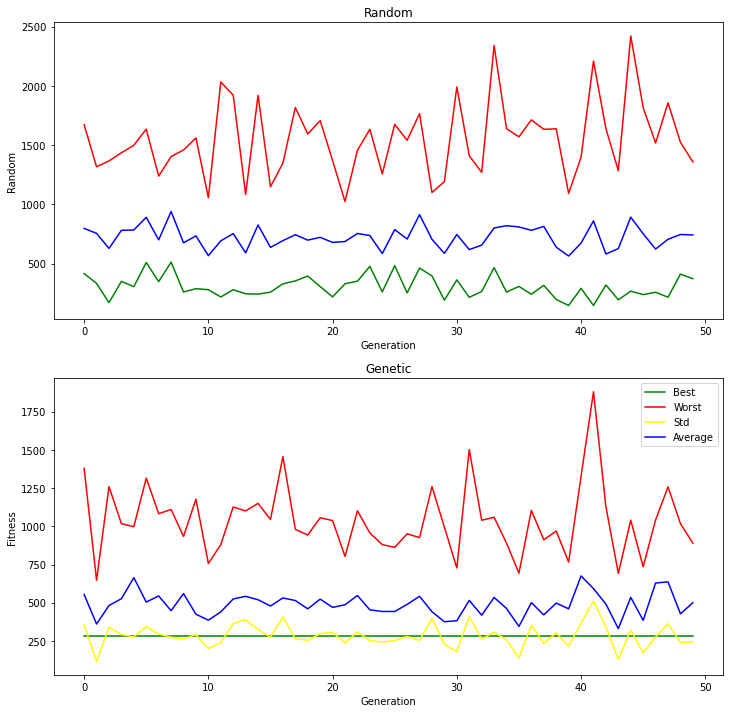

In [10]:
root = tk.Tk()
root.title('Lab1')
root.resizable(False, False)

FULL_WIDTH = board_width * SPACE_BETWEEN_POINTS
FULL_HEIGHT = board_height * SPACE_BETWEEN_POINTS

w = tk.Canvas(root, width=FULL_WIDTH, height=FULL_HEIGHT, bg="#505050")
w.pack()
root.update()


def draw_result(individual: Individual):
    offset = SPACE_BETWEEN_POINTS / 2
    for path in individual.paths:
        x, y = path.xstart * SPACE_BETWEEN_POINTS, path.ystart * SPACE_BETWEEN_POINTS
        for segment in path.segments:
            x_distance, y_distance = 0, 0

            if segment.direction in ('U', 'D'):
                 y_distance = SPACE_BETWEEN_POINTS
            if segment.direction in ('L', 'R'):
                 x_distance = SPACE_BETWEEN_POINTS
            
            x_rotate, y_rotate = 1, 1
            if segment.direction == 'U': 
                y_rotate = -1
            if segment.direction == 'L': 
                x_rotate = -1

            for i in range(segment.distance):
                w.create_line(x - offset, y - offset, x + x_distance * x_rotate - offset, y - offset + y_rotate * y_distance, fill=path.color)
                if segment.direction == 'U':
                     y -= SPACE_BETWEEN_POINTS
                if segment.direction == 'D': 
                    y += SPACE_BETWEEN_POINTS
                if segment.direction == 'L': 
                    x -= SPACE_BETWEEN_POINTS
                if segment.direction == 'R':
                     x += SPACE_BETWEEN_POINTS


def draw_board():
    #Draw background dots
    for x in range(0, FULL_WIDTH, SPACE_BETWEEN_POINTS):
        for y in range(0, FULL_HEIGHT, SPACE_BETWEEN_POINTS):
            draw_circle(w, x, y, x + SPACE_BETWEEN_POINTS, y + SPACE_BETWEEN_POINTS, offset=2)


def draw_circle(w, x1, y1, x2, y2, offset=2, color='#bbb'):
    #To draw circle
    offset = SPACE_BETWEEN_POINTS / offset
    w.create_oval(x1 + offset, y1 + offset, x2 - offset, y2 - offset, fill=color, outline='')


def draw_vectors():
    #To draw points
    for coordinate in coordinates:
        coordinate = list(map(lambda coord: (coord - 1) * SPACE_BETWEEN_POINTS, coordinate))
        x1 = coordinate[0]
        y1 = coordinate[1]
        x2 = coordinate[2]
        y2 = coordinate[3]
        draw_circle(w, x1, y1, x1 + SPACE_BETWEEN_POINTS, y1 + SPACE_BETWEEN_POINTS, offset=3, color='#aaa')
        draw_circle(w, x2, y2, x2 + SPACE_BETWEEN_POINTS, y2 + SPACE_BETWEEN_POINTS, offset=3, color='#aaa')


for i,individual in enumerate(genetic_population):
    #To cleanup the board for new further results
    w.delete('all')
    draw_board()
    draw_result(individual)
    draw_vectors()
    EpsImagePlugin.gs_windows_binary =  r'D:/Program Files/gs/gs9.53.3/bin/gswin64c'
    filename = f"results/{i}_stage"
    w.postscript(file=filename + '.eps', colormode = 'color')
    img = Image.open(filename + '.eps')
    img.save(filename + '.png','png')

    with open('result.txt', 'w') as f:
        f.write(str(individual))


print("--- %s seconds ---" % round(time.time() - start_time, 2)) 
root.mainloop()